# Optimal network reinforcement solution for distributed generation rise.

Description of the project

In [248]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.topology
import pandapower.plotting
import pandapower.converter
import pandapower.estimation
from pandapower.plotting import cmap_continuous, cmap_discrete, create_bus_collection, create_line_collection, draw_collections,create_trafo_collection
import pandas as pd
import numpy as np

### Functions

In [254]:
#Initialisation
def Init(pmw_gen=10):
    net = pn.mv_oberrhein("generation")
    #Calculate the length of the lines
    for i,length in zip(net.line.index,net.line['length_km']):
        x1,y1 = float(net.bus_geodata['x'][net.line['from_bus'][i]]), float(net.bus_geodata['y'][net.line['from_bus'][i]])
        x2,y2 = float(net.bus_geodata['x'][net.line['to_bus'][i]]), float(net.bus_geodata['y'][net.line['to_bus'][i]])
        net.line['length_km'][i] = np.sqrt((x1-x2)**2+(y1-y2)**2)/300 #factor for convergence
    #Move position of external grid in order to be able to see the transformer
    net.bus_geodata['x'][318], net.bus_geodata['y'][318] = 3408302.042,5367780.101
    net.bus_geodata['x'][58], net.bus_geodata['y'][58] = 3420000.660 , 5369458.703
    #Drop all already in static generators
    for i,_ in enumerate(net.sgen['p_mw']):
        net.sgen = net.sgen.drop(i)
    #Creating the generator
    x_gen, y_gen = 3406223.643,5364479.401 #Determine on QGis
    pp.create_bus(net,geodata=(x_gen,y_gen),vn_kv=20.0,min_vm_pu=0.9,max_vm_pu=1.1,name='Bus 179',index=320) #Change the value of vn_kv?
    #Create generator at the created node (200)
    pp.create_gen(net,320,p_mw=pmw_gen) #Change the p_mw, max and min value?
    return net

#Technical violation functions
    #Visual plot
def Plot(net): #Plot map with in red the problematic(s) line(s),node(s) or transformator(s)
    # plot network with color codes
    cmap_list_node = [((0,0.9), "orangered"), ((0.9,1.1), "blue"), ((1.1,2), "red")]
    cmap_n, norm_n = cmap_discrete(cmap_list_node)
    bc = create_bus_collection(net, size=70, cmap=cmap_n, norm=norm_n);
    
    cmap_list_line = [((0, 95), "green"),((95,100),"yellow"), ((100, 200), "red")]
    cmap_l, norm_l = cmap_discrete(cmap_list_line)
    lc = create_line_collection(net, cmap=cmap_l, norm=norm_l,use_bus_geodata=True)
    
    cmap_list_trafo = [((0, 95), "lightgreen"),((95,100),"gold"), ((100, 200), "tomato")]
    cmap_t, norm_t = cmap_discrete(cmap_list_trafo)
    tc = create_trafo_collection(net,cmap=cmap_t, norm=norm_t)
    
    draw_collections([bc,tc,lc])

    # check constraints violation - voltage - bus
def isVoltageViolation(net):
    vMin,vMax, Node = 0.9, 1.1, [] #Init
    for k,v in enumerate(net.res_bus['vm_pu']):
        if v>vMax or v<vMin: #if violation
            Node.append(k)  #save the bus index
    return Node

    # check constraints violation - current - line
def isCurrentViolation(net):
    iMax, Line = net.line['max_i_ka'], [] #Init
    for k,i in zip(net.line.index,net.res_line['i_ka']):
        if i>iMax[k]: #if violation
            Line.append(k) #save the line index
    return Line

    # check constraints violation - load - transformer
def isTransformerViolation(net):
    loadmax, Trafo = 100, []
    for k, t in enumerate(net.res_trafo['loading_percent']):
        if t>loadmax: #if violation
            Trafo.append(k) #save the trafo index
    return Trafo
    
    #Return boolean of "is there violation?" with the value of bus, line and transfo that the limiting factor.
def isThereViolation(net,plot=False):
    if plot:
        Plot(net)
    N,L,T = isVoltageViolation(net),  isCurrentViolation(net),  isTransformerViolation(net)
    if N!=[] or L!=[] or T!=[]:
        return True, N, L , T
    return False, N, L, T

#Function of connexion

    #Connect the generator to the network at bus "node". plot the line
def ConnexionGen(net, node, plot=True):
    x_nod = float(net.bus_geodata['x'][net.bus_geodata.index==node])
    y_nod = float(net.bus_geodata['y'][net.bus_geodata.index==node])
    x_gen, y_gen = 3406223.643,5364479.401 #Determine on QGis
    len_con = np.sqrt((x_gen-x_nod)**2+(y_gen-y_nod)**2)/300 #factor for convergence
    pp.create_line(net,320,node,length_km=len_con,std_type="490-AL1/64-ST1A 380.0") #generator at bus 320
    pp.runpp(net)
    return isThereViolation(net,plot=plot),len_con

    #Change the problematic component (for now just lines)
def ChangeComp(net,id_node,id_line,id_trafo, pmw_gen=10,plot=True):
    net.gen.p_mw[0] = pmw_gen
    for l in id_line:
        fromb,tob,lenb = network.line['from_bus'][l],network.line['to_bus'][l],network.line['length_km'][l] #extract data
        network.line = network.line.drop(l) #drop the problematic line
        pp.create_line(net,fromb,tob,length_km=lenb,std_type="490-AL1/64-ST1A 380.0",index=l) #replace it
    Tr = [114,142]
    for t in id_trafo:
        fromb,tob = network.trafo['hv_bus'][Tr[t]],network.trafo['lv_bus'][Tr[t]] #extract data
        network.trafo = network.trafo.drop(Tr[t]) #drop the problematic trafo
        pp.create_transformer(net,fromb,tob,std_type="63 MVA 110/20 kV",index=Tr[t]) #replace it
    # for nodes: analyse the lines around the nodes to change them
    # Add the prices of change
    pp.runpp(net)
    return isThereViolation(network,plot=plot)

    #return max power of the added generator for the given network organisation
def MaxPow(net, p_min = 0, p_max = 30,N=100): 
    i=0
    while i<N:
        p_mw = (p_min+p_max)/2
        net.gen['p_mw'][0] = p_mw
        pp.runpp(net)
        if not isThereViolation(net)[0]:
            p_min = p_mw
        else:
            p_max = p_mw
        i+=1
    return net.gen['p_mw'][0]


#"Optimisation" functions
    #Function to calculate the max power achievable for all node connexions
    # Create a simple line, not a transformer
def MaxPowWithoutProb(net,p_max=25,p_max2=40):
    MAX = []
    for j,i in enumerate(net.bus.index[:179]): #avoid doing the calculation with gen connected to himself
        net = Init()
        ConnexionGen(net,i,plot=False)
        MAX.append([MaxPow(net,p_max=p_max),i])
        if j%int(len(net.bus.index)/4)==0: #plot the advancement of the function every 25%
            print(f'{j/len(net.bus.index)*100}%')
    for i,k in [(maxi[1],i) for i,maxi in enumerate(MAX) if maxi[0]==p_max]: #divide to avoid divergence for low gen capacity node connexions
        net = Init()
        ConnexionGen(net,i,plot=False)
        MAX[k][0]=MaxPow(net,p_max=p_max2)
    return MAX

 ### Initial network: Oberrhein case study with a generator to connect

This pandapower network includes the following parameter tables:
   - bus (180 elements)
   - load (147 elements)
   - gen (1 element)
   - switch (322 elements)
   - ext_grid (2 elements)
   - line (181 elements)
   - trafo (2 elements)
   - line_geodata (181 elements)
   - bus_geodata (180 elements)
 and the following results tables:
   - res_bus (180 elements)
   - res_line (181 elements)
   - res_trafo (2 elements)
   - res_ext_grid (2 elements)
   - res_load (147 elements)
   - res_gen (1 element)
   - res_switch (322 elements)


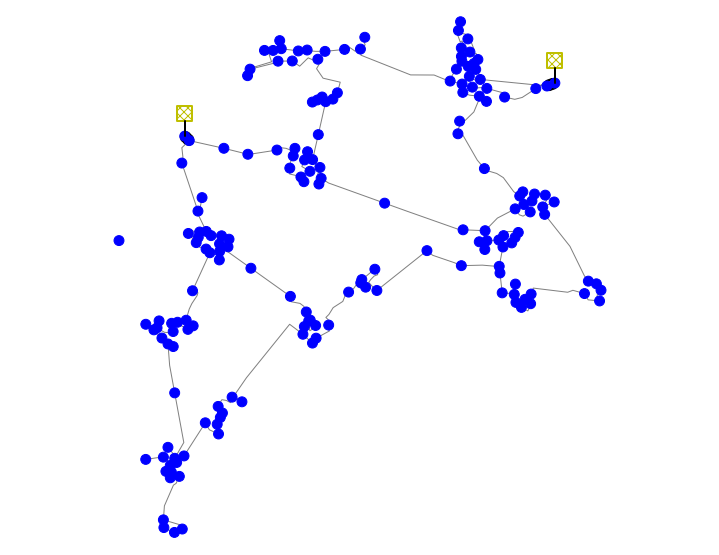

In [255]:
network = Init()
pp.runpp(network)
print(network)
#pandapower.to_excel(network, "AC_datas.xlsx")
pandapower.plotting.simple_plot(network);

Length = 12.87391031081326km ; Pb_bus=[] ; Pb_line=[] ; Pb_trafo=[1]
Max gen power = 29.683490030886617


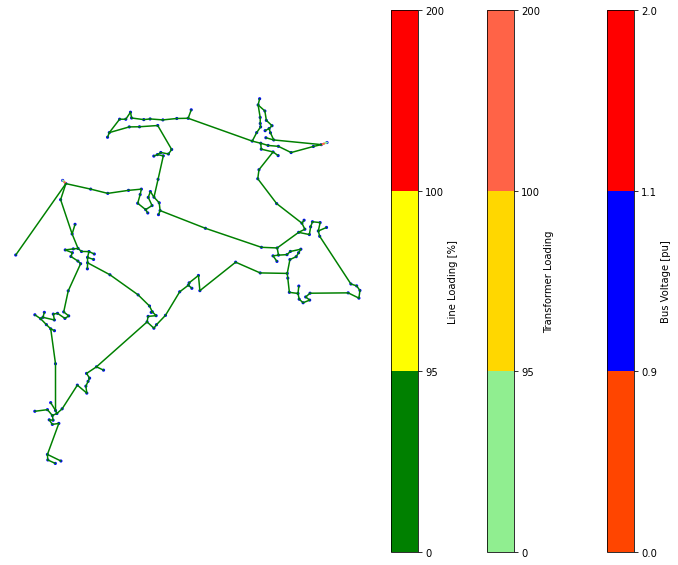

In [256]:
# Exemple with problem
network = Init(pmw_gen = 30)
pp.runpp(network)
PB,length = ConnexionGen(network,319);print(f'Length = {length}km ; Pb_bus={PB[1]} ; Pb_line={PB[2]} ; Pb_trafo={PB[3]}')
maxg = MaxPow(network,p_max=100); print(f'Max gen power = {maxg}')

Pb_bus=[] ; Pb_line=[194] ; Pb_trafo=[]
Max gen power = 33.20176456283981


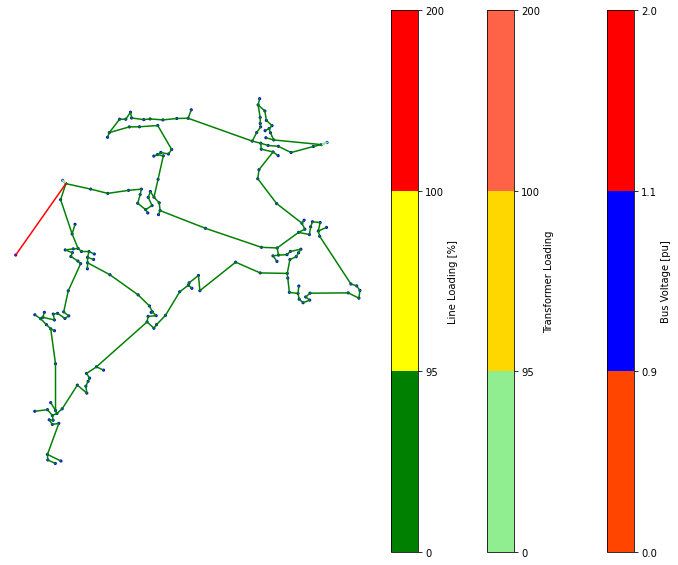

In [257]:
#Exemple of change trafo
PB = ChangeComp(network,PB[1],PB[2],PB[3],pmw_gen=35);print(f'Pb_bus={PB[1]} ; Pb_line={PB[2]} ; Pb_trafo={PB[3]}')
maxg = MaxPow(network,p_max = 40); print(f'Max gen power = {maxg}')

In [260]:
MAX = MaxPowWithoutProb(network)
print([MAX[i] for i in range(0,179) if MAX[i][0]>18])
MaxGen = pd.DataFrame(data = MAX)
MaxGen.to_excel('Max_gen_oberrhein.xlsx') #save the datas

[[25.018875981734325, 6], [24.866428297695343, 7], [24.347119364635283, 29], [24.380124624767852, 30], [27.67889479624074, 39], [31.50818910117065, 58], [23.757946538057325, 71], [23.69977738275381, 73], [23.837183699137462, 80], [23.755465634687887, 86], [24.311935742377926, 126], [24.846464794023213, 290], [33.12521565255001, 318], [29.68349003088533, 319]]
